In [161]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_statevector, state_fidelity
from scipy.stats import entropy

from src.Qubo import Qubo
from src.Chain import Chain
from src.Grid import Grid
from src.Qulacs_CP_VQA import Qulacs_CP_VQA

In [162]:
# Function to compute fidelity between two states
def fidelity(state1, state2):
    return np.abs(np.dot(np.conj(state1), state2))**2

def generate_haar_random_states(num_states, dim):
    return [random_statevector(dim).data for _ in range(num_states)]

def calculate_fidelity_distribution(states1, states2):
    fidelities = []
    for state1 in states1:
        for state2 in states2:
            fidelity = state_fidelity(state1, state2)
            fidelities.append(fidelity)
    return fidelities

def plot_normalized_histogram(fidelities: np.ndarray, 
                              N_bins: int, 
                              color: str):
    frequencies, x_lims = np.histogram(fidelities, bins=N_bins, density=True)
    normalized_frequencies = frequencies / np.sum(frequencies)
    w = x_lims[1]-x_lims[0]
    for f,x in zip(normalized_frequencies,x_lims):
        plt.bar(x, f, w, 0, color=color, alpha=0.5)    

def calculate_kl_divergence(dist1, dist2):
    return entropy(dist1, dist2)

In [169]:
qubits, layers = 4, 2
seed = 1
np.random.seed(seed)
alpha = 0.5
w_nnn = False
init_strat = np.array([1 if i%2 == 1 else 0 for i in range(qubits)])
my_indices = [(i, i+1) for i in range(qubits-1)]
# Defining topology
my_chain = Chain(N_qubits=qubits)
my_chain.set_initialization_strategy(strategy=init_strat)

my_grid = Grid(N_qubits=qubits)
my_grid.set_initialization_strategy(strategy=np.array([[0,1],
                                                       [1,0]]))
# Deciding between grid and 1d chain topology
my_topology = my_chain
Q = np.triu(np.random.uniform(-1,1,(qubits,qubits)))
qubo = Qubo(Q=Q, offset=np.random.uniform(-1,1))
ansatz = Qulacs_CP_VQA(N_qubits=qubits, cardinality=qubits//2, 
                       layers=layers, qubo=qubo, 
                       with_next_nearest_neighbors=w_nnn,
                       topology=my_topology, use_parametric_circuit_opt=True)

In [170]:
N_samples = 350
sampled_states = []
for sample in range(N_samples):
    n_angles = layers * len(my_topology.get_NNN_indices()) if w_nnn else layers * len(my_topology.get_NN_indices())
    angles = np.random.uniform(-2*np.pi, 2*np.pi, layers * len(my_topology.get_NN_indices()))
    psi = ansatz.get_statevector(angles=angles)
    sampled_states.append(psi)

KL Divergence: 1.4966709644526766


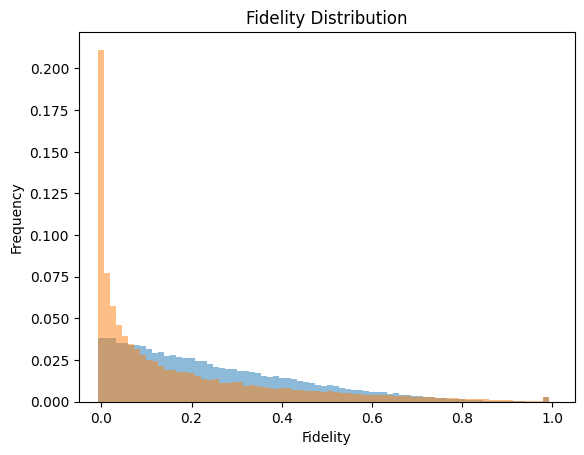

In [171]:
# Parameters
num_haar_states = N_samples  # Adjust as needed
num_pqc_states = N_samples   # Adjust as needed
dim = qubits           # Adjust for the dimension of your quantum system

# Generate states
haar_states = generate_haar_random_states(num_haar_states, dim)
pqc_states = sampled_states  # Replace this with your PQC states

# Calculate fidelity distributions
fidelities_haar = calculate_fidelity_distribution(haar_states, haar_states)
fidelities_pqc = calculate_fidelity_distribution(pqc_states, pqc_states)

# Plot histograms
plot_normalized_histogram(fidelities=fidelities_haar,N_bins=75,color='tab:blue')
plot_normalized_histogram(fidelities=fidelities_pqc, N_bins=75,color='tab:orange')
plt.xlim(-0.05,1.05)
plt.xlabel('Fidelity')
plt.ylabel('Frequency')
plt.title('Fidelity Distribution')
# Calculate and print KL divergence
kl_div = calculate_kl_divergence(fidelities_haar, fidelities_pqc)
print(f"KL Divergence: {kl_div}")
